## Bidirectional Long Short Term Memory Cells Model

### Import necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import html
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

### Data Preprocessing and Preperation

In [2]:
# Load Data
df = pd.read_csv('tweets.csv')

# Text Preprocessing Functions
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+', flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    return html_tag.sub(r'', text)

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation + "“”’‘"))

def remove_html_entities(text):
    return html.unescape(text)

# Apply Preprocessing
df['text_clean'] = df['text'].apply(remove_URL)
df['text_clean'] = df['text_clean'].apply(remove_emoji)
df['text_clean'] = df['text_clean'].apply(remove_html)
df['text_clean'] = df['text_clean'].apply(remove_html_entities)
df['text_clean'] = df['text_clean'].apply(remove_punct)

# Tokenizing the clean text
df['tokenized'] = df['text_clean'].apply(word_tokenize)

# Lowercasing the tokenized text
df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

# Removing stopwords
stop = set(stopwords.words('english'))
df['stopwords_removed'] = df['lower'].apply(lambda x: [word for word in x if word not in stop])

# Apply Lemmatization
wnl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x if tag is not None])
df['final_text'] = df['lemmatized'].apply(' '.join)

# Splitting the Data
X = df['final_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Tokenisation

In [3]:
# Tokenize the data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Handle class imbalance by oversampling the minority class
train_data = pd.concat([pd.DataFrame(X_train_pad), pd.Series(y_train).reset_index(drop=True)], axis=1)
train_majority = train_data[train_data[train_data.columns[-1]] == train_data[train_data.columns[-1]].mode()[0]]
train_minority = train_data[train_data[train_data.columns[-1]] != train_data[train_data.columns[-1]].mode()[0]]

train_minority_upsampled = resample(train_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=len(train_majority),    # to match majority class
                                    random_state=42) # reproducible results

train_upsampled = pd.concat([train_majority, train_minority_upsampled])

X_train_sm = train_upsampled.iloc[:, :-1].values
y_train_sm = train_upsampled.iloc[:, -1].values

### Model fitting and evaluation of BiLSTM with Word Embedding

Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


231/231 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - f1_score: 0.6957 - loss: 0.5823 - val_f1_score: 0.6952 - val_loss: 0.3029
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - f1_score: 0.9134 - loss: 0.2366 - val_f1_score: 0.6947 - val_loss: 0.3014
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - f1_score: 0.9582 - loss: 0.1340 - val_f1_score: 0.6612 - val_loss: 0.3909
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - f1_score: 0.9669 - loss: 0.1076 - val_f1_score: 0.6620 - val_loss: 0.4444
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - f1_score: 0.9747 - loss: 0.0813 - val_f1_score: 0.6523 - val_loss: 0.4853


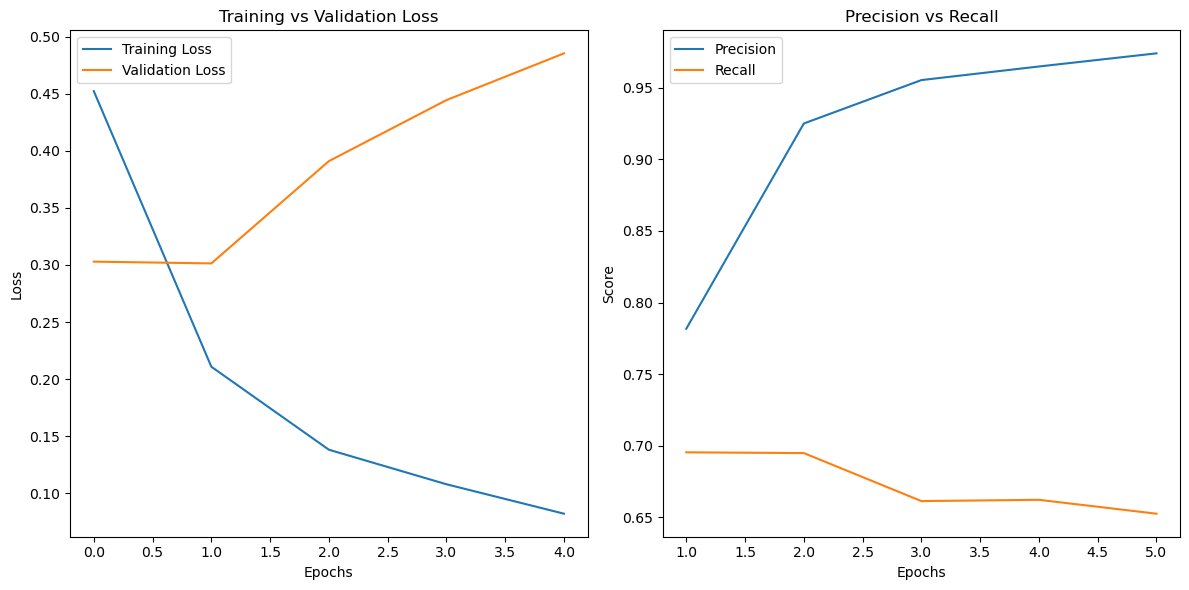

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
LSTM Model Evaluation:
Accuracy: 0.8883
Precision: 0.6628
Recall: 0.7298
F1 Score: 0.6947


In [4]:
# Define a custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=50, input_length=max_len))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
lstm_model.add(Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[F1Score()])

# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train_sm, y_train_sm,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss')]
)


train_loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

# Plotting the loss
plt.figure(figsize=(12, 6))

# Plot Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Precision vs Recall
# Extracting the precision and recall from the history object
precision = lstm_history.history['f1_score']
recall = lstm_history.history['val_f1_score']  # Assuming this is stored, usually not the case, need to calculate manually
epochs = range(1, len(precision) + 1)

plt.subplot(1, 2, 2)
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.title('Precision vs Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


# Make predictions on the test data
y_pred_probs = lstm_model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

# Evaluate the predictions
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("LSTM Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

### Hyper Parameter Tuning of BiLSTM model with Word Embedding

In [5]:
def create_lstm_model(lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=50, input_length=max_len))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    model.add(Bidirectional(LSTM(lstm_units // 2, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=[F1Score()])
    return model


Testing parameters:
LSTM units: 32
Dropout rate: 0.2
Learning rate: 0.001
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - f1_score: 0.1172 - loss: 0.5104 - val_f1_score: 0.6359 - val_loss: 0.2803
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - f1_score: 0.7324 - loss: 0.2513 - val_f1_score: 0.6918 - val_loss: 0.2610
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - f1_score: 0.8309 - loss: 0.1825 - val_f1_score: 0.6923 - val_loss: 0.2637
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - f1_score: 0.8755 - loss: 0.1379 - val_f1_score: 0.6877 - val_loss: 0.3071
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - f1_score: 0.9024 - loss: 0.1094 - val_f1_score: 0.6809 - val_loss: 0.3472
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Evaluation results:
F1 Score: 0.6918
Precision: 0.7406
Recall: 0.6490

Best model updated!

Testing parameters:
LSTM units: 32
Dropout rate: 0.2
Learning rate: 0.001
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - f1_score: 0.0368 - loss: 0.5280 - val_f1_score: 0.6494 - val_loss: 0.2896
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - f1_score: 0.7132 - loss: 0.2830 - val_f1_score: 0.6948 - val_loss: 0.2603
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - f1_score: 0.8221 - loss: 0.1905 - val_f1_score: 0.6883 - val_loss: 0.2693
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - f1_score: 0.8737 - loss: 0.1483 - val_f1_score: 0.6833 - val_loss: 0.2846
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - f1_score: 0.9015 - loss: 0.1180 - val_f1_score: 0.6755 - val_loss: 0.3049
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Evaluation results:
F1 Score: 0.6948
Precision: 0.7285
Recall: 0.6641

Best model updated!

Testing parameters:
LSTM units: 32
Dropout rate: 0.2
Learning rate: 0.005
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - f1_score: 0.2737 - loss: 0.4356 - val_f1_score: 0.6823 - val_loss: 0.2792
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - f1_score: 0.7858 - loss: 0.2189 - val_f1_score: 0.6860 - val_loss: 0.2571
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - f1_score: 0.8481 - loss: 0.1575 - val_f1_score: 0.6738 - val_loss: 0.3162
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - f1_score: 0.8926 - loss: 0.1155 - val_f1_score: 0.6798 - val_loss: 0.4029
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - f1_score: 0.9311 - loss: 0.0799 - val_f1_score: 0.6729 - val_loss: 0.4213
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Evaluation results:
F1 Score: 0.6860
Precision: 0.8034
Recall: 0.5985


Testing parameters:
LSTM units: 32
Dropout rate: 0.2
Learning rate: 0.005
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - f1_score: 0.2250 - loss: 0.4473 - val_f1_score: 0.6752 - val_loss: 0.2728
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - f1_score: 0.7849 - loss: 0.2263 - val_f1_score: 0.6967 - val_loss: 0.2542
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - f1_score: 0.8723 - loss: 0.1471 - val_f1_score: 0.6797 - val_loss: 0.2883
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - f1_score: 0.9137 - loss: 0.1012 - val_f1_score: 0.6583 - val_loss: 0.3845
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - f1_score: 0.9334 - loss: 0.0705 - val_f1_score: 0.6538 - val_loss: 0.3641
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Evaluation results:
F1 Score: 0.6967
Precision: 0.7589
Recall: 0.6439

Best model updated!

Testing parameters:
LSTM units: 32
Dropout rate: 0.3
Learning rate: 0.001
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - f1_score: 0.0563 - loss: 0.5074 - val_f1_score: 0.6333 - val_loss: 0.2846
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - f1_score: 0.7081 - loss: 0.2784 - val_f1_score: 0.6762 - val_loss: 0.2632
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - f1_score: 0.8244 - loss: 0.1812 - val_f1_score: 0.6856 - val_loss: 0.2634
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - f1_score: 0.8773 - loss: 0.1437 - val_f1_score: 0.6942 - val_loss: 0.2938
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - f1_score: 0.8834 - loss: 0.1355 - val_f1_score: 0.6824 - val_loss: 0.3142
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Evaluation results:
F1 Score: 0.6762
Precision: 0.7770
Recall: 0.5985


Testing parameters:
LSTM units: 32
Dropout rate: 0.3
Learning rate: 0.001
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - f1_score: 0.0473 - loss: 0.5491 - val_f1_score: 0.0000e+00 - val_loss: 0.4058
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - f1_score: 0.3991 - loss: 0.3481 - val_f1_score: 0.6951 - val_loss: 0.2614
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - f1_score: 0.7790 - loss: 0.2193 - val_f1_score: 0.6925 - val_loss: 0.2596
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - f1_score: 0.8301 - loss: 0.1803 - val_f1_score: 0.7023 - val_loss: 0.2949
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - f1_score: 0.8717 - loss: 0.1437 - val_f1_score: 0.6887 - val_loss: 0.2964
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - f1_score: 0.9063 - loss: 0.1179 - val_f1_score: 0.6914 - val_loss: 0.3300
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Evaluation results:
F1 Score: 0.6925
Precision: 0.7669
Recall: 0.6313


Testing parameters:
LSTM units: 32
Dropout rate: 0.3
Learning rate: 0.005
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - f1_score: 0.2919 - loss: 0.4461 - val_f1_score: 0.6676 - val_loss: 0.2630
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - f1_score: 0.7495 - loss: 0.2477 - val_f1_score: 0.6684 - val_loss: 0.2653
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - f1_score: 0.8361 - loss: 0.1791 - val_f1_score: 0.6802 - val_loss: 0.2920
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - f1_score: 0.8697 - loss: 0.1277 - val_f1_score: 0.6712 - val_loss: 0.3047
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Evaluation results:
F1 Score: 0.6676
Precision: 0.7850
Recall: 0.5808


Testing parameters:
LSTM units: 32
Dropout rate: 0.3
Learning rate: 0.005
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - f1_score: 0.2039 - loss: 0.4632 - val_f1_score: 0.6733 - val_loss: 0.2664
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - f1_score: 0.7634 - loss: 0.2376 - val_f1_score: 0.6647 - val_loss: 0.2624
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - f1_score: 0.8143 - loss: 0.1822 - val_f1_score: 0.6724 - val_loss: 0.2794
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - f1_score: 0.8755 - loss: 0.1287 - val_f1_score: 0.6716 - val_loss: 0.3498
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - f1_score: 0.8910 - loss: 0.1040 - val_f1_score: 0.6621 - val_loss: 0.3761
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Evaluation results:
F1 Score: 0.6647
Precision: 0.8007
Recall: 0.5682


Testing parameters:
LSTM units: 64
Dropout rate: 0.2
Learning rate: 0.001
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - f1_score: 0.1515 - loss: 0.4747 - val_f1_score: 0.6608 - val_loss: 0.2670
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - f1_score: 0.7573 - loss: 0.2348 - val_f1_score: 0.6813 - val_loss: 0.2600
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - f1_score: 0.8510 - loss: 0.1676 - val_f1_score: 0.6966 - val_loss: 0.2792
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - f1_score: 0.8965 - loss: 0.1219 - val_f1_score: 0.6831 - val_loss: 0.3055
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - f1_score: 0.9245 - loss: 0.0848 - val_f1_score: 0.6569 - val_loss: 0.3605
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Evaluation results:
F1 Score: 0.6813
Precision: 0.8090
Recall: 0.5884


Testing parameters:
LSTM units: 64
Dropout rate: 0.2
Learning rate: 0.001
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - f1_score: 0.0572 - loss: 0.4983 - val_f1_score: 0.6532 - val_loss: 0.2766
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - f1_score: 0.7285 - loss: 0.2568 - val_f1_score: 0.6868 - val_loss: 0.2551
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - f1_score: 0.8313 - loss: 0.1782 - val_f1_score: 0.6695 - val_loss: 0.2688
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - f1_score: 0.8609 - loss: 0.1429 - val_f1_score: 0.6860 - val_loss: 0.3042
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - f1_score: 0.9110 - loss: 0.1035 - val_f1_score: 0.6733 - val_loss: 0.3446
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Evaluation results:
F1 Score: 0.6868
Precision: 0.7530
Recall: 0.6313


Testing parameters:
LSTM units: 64
Dropout rate: 0.2
Learning rate: 0.005
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - f1_score: 0.3349 - loss: 0.4255 - val_f1_score: 0.6507 - val_loss: 0.2679
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - f1_score: 0.7640 - loss: 0.2222 - val_f1_score: 0.6897 - val_loss: 0.2646
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - f1_score: 0.8571 - loss: 0.1482 - val_f1_score: 0.6913 - val_loss: 0.3209
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - f1_score: 0.8942 - loss: 0.1072 - val_f1_score: 0.6469 - val_loss: 0.3564
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - f1_score: 0.9296 - loss: 0.0779 - val_f1_score: 0.6723 - val_loss: 0.4914
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Evaluation results:
F1 Score: 0.6897
Precision: 0.7599
Recall: 0.6313


Testing parameters:
LSTM units: 64
Dropout rate: 0.2
Learning rate: 0.005
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - f1_score: 0.2625 - loss: 0.4515 - val_f1_score: 0.6518 - val_loss: 0.2614
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - f1_score: 0.8019 - loss: 0.2138 - val_f1_score: 0.6636 - val_loss: 0.2774
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - f1_score: 0.8412 - loss: 0.1539 - val_f1_score: 0.6869 - val_loss: 0.2894
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - f1_score: 0.9087 - loss: 0.1075 - val_f1_score: 0.6789 - val_loss: 0.3500
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
Evaluation results:
F1 Score: 0.6518
Precision: 0.7935
Recall: 0.5530


Testing parameters:
LSTM units: 64
Dropout rate: 0.3
Learning rate: 0.001
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - f1_score: 0.0967 - loss: 0.5065 - val_f1_score: 0.6610 - val_loss: 0.2771
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - f1_score: 0.7308 - loss: 0.2500 - val_f1_score: 0.6667 - val_loss: 0.2555
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - f1_score: 0.8076 - loss: 0.1914 - val_f1_score: 0.6967 - val_loss: 0.2641
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - f1_score: 0.8601 - loss: 0.1478 - val_f1_score: 0.6817 - val_loss: 0.2991
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - f1_score: 0.8790 - loss: 0.1256 - val_f1_score: 0.6767 - val_loss: 0.3567
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
Evaluation results:
F1 Score: 0.6667
Precision: 0.7778
Recall: 0.5833


Testing parameters:
LSTM units: 64
Dropout rate: 0.3
Learning rate: 0.001
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - f1_score: 0.0289 - loss: 0.5116 - val_f1_score: 0.6667 - val_loss: 0.2884
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - f1_score: 0.7051 - loss: 0.2830 - val_f1_score: 0.6782 - val_loss: 0.2578
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - f1_score: 0.7931 - loss: 0.2042 - val_f1_score: 0.6963 - val_loss: 0.2630
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - f1_score: 0.8434 - loss: 0.1567 - val_f1_score: 0.6806 - val_loss: 0.2908
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - f1_score: 0.8840 - loss: 0.1286 - val_f1_score: 0.6757 - val_loss: 0.3124
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
Evaluation results:
F1 Score: 0.6782
Precision: 0.7867
Recall: 0.5960


Testing parameters:
LSTM units: 64
Dropout rate: 0.3
Learning rate: 0.005
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - f1_score: 0.2935 - loss: 0.4448 - val_f1_score: 0.6619 - val_loss: 0.2744
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - f1_score: 0.7613 - loss: 0.2388 - val_f1_score: 0.6800 - val_loss: 0.2850
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - f1_score: 0.8300 - loss: 0.1789 - val_f1_score: 0.6788 - val_loss: 0.3004
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - f1_score: 0.8823 - loss: 0.1273 - val_f1_score: 0.6911 - val_loss: 0.3286
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
Evaluation results:
F1 Score: 0.6619
Precision: 0.7565
Recall: 0.5884


Testing parameters:
LSTM units: 64
Dropout rate: 0.3
Learning rate: 0.005
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - f1_score: 0.2741 - loss: 0.4589 - val_f1_score: 0.6522 - val_loss: 0.2640
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - f1_score: 0.7519 - loss: 0.2401 - val_f1_score: 0.6967 - val_loss: 0.2533
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - f1_score: 0.8112 - loss: 0.1783 - val_f1_score: 0.6910 - val_loss: 0.2814
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - f1_score: 0.8863 - loss: 0.1303 - val_f1_score: 0.6789 - val_loss: 0.3469
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - f1_score: 0.9059 - loss: 0.1076 - val_f1_score: 0.6786 - val_loss: 0.3474
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
Evaluation results:
F1 Score: 0.6967
Precision: 0.8191
Recall: 0.6061


Testing parameters:
LSTM units: 128
Dropout rate: 0.2
Learning rate: 0.001
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step - f1_score: 0.2276 - loss: 0.4585 - val_f1_score: 0.6262 - val_loss: 0.2848
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - f1_score: 0.7674 - loss: 0.2299 - val_f1_score: 0.6984 - val_loss: 0.2563
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 43s 149ms/step - f1_score: 0.8469 - loss: 0.1618 - val_f1_score: 0.6733 - val_loss: 0.2703
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 43s 149ms/step - f1_score: 0.8907 - loss: 0.1164 - val_f1_score: 0.6695 - val_loss: 0.2946
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - f1_score: 0.9221 - loss: 0.0896 - val_f1_score: 0.6760 - val_loss: 0.3514
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step
Evaluation results:
F1 Score: 0.6984
Precision: 0.7559
Recall: 0.6490

Best model updated!

Testing parameters:
LSTM units: 128
Dropout rate: 0.2
Learning rate: 0.001
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 393ms/step - f1_score: 0.1007 - loss: 0.5052 - val_f1_score: 0.6436 - val_loss: 0.2768
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - f1_score: 0.7408 - loss: 0.2455 - val_f1_score: 0.6923 - val_loss: 0.2632
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - f1_score: 0.8322 - loss: 0.1753 - val_f1_score: 0.6769 - val_loss: 0.2776
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - f1_score: 0.8704 - loss: 0.1386 - val_f1_score: 0.6749 - val_loss: 0.3045
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - f1_score: 0.9094 - loss: 0.1061 - val_f1_score: 0.6739 - val_loss: 0.3479
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step
Evaluation results:
F1 Score: 0.6923
Precision: 0.7291
Recall: 0.6591


Testing parameters:
LSTM units: 128
Dropout rate: 0.2
Learning rate: 0.005
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 54s 169ms/step - f1_score: 0.3590 - loss: 0.4306 - val_f1_score: 0.6851 - val_loss: 0.2796
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 48s 167ms/step - f1_score: 0.7692 - loss: 0.2265 - val_f1_score: 0.6717 - val_loss: 0.2634
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 48s 168ms/step - f1_score: 0.8637 - loss: 0.1494 - val_f1_score: 0.6693 - val_loss: 0.3310
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 48s 168ms/step - f1_score: 0.9013 - loss: 0.1032 - val_f1_score: 0.6791 - val_loss: 0.3208
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 48s 168ms/step - f1_score: 0.9211 - loss: 0.0739 - val_f1_score: 0.6750 - val_loss: 0.4301
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step
Evaluation results:
F1 Score: 0.6717
Precision: 0.8266
Recall: 0.5657


Testing parameters:
LSTM units: 128
Dropout rate: 0.2
Learning rate: 0.005
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - f1_score: 0.2980 - loss: 0.4365 - val_f1_score: 0.6879 - val_loss: 0.2601
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 373ms/step - f1_score: 0.7927 - loss: 0.2091 - val_f1_score: 0.6694 - val_loss: 0.2734
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 372ms/step - f1_score: 0.8482 - loss: 0.1513 - val_f1_score: 0.6575 - val_loss: 0.3159
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 373ms/step - f1_score: 0.9005 - loss: 0.1074 - val_f1_score: 0.6692 - val_loss: 0.3614
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step
Evaluation results:
F1 Score: 0.6879
Precision: 0.7631
Recall: 0.6263


Testing parameters:
LSTM units: 128
Dropout rate: 0.3
Learning rate: 0.001
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - f1_score: 0.1228 - loss: 0.4704 - val_f1_score: 0.6244 - val_loss: 0.2741
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - f1_score: 0.7363 - loss: 0.2416 - val_f1_score: 0.6686 - val_loss: 0.2744
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - f1_score: 0.8186 - loss: 0.1878 - val_f1_score: 0.6882 - val_loss: 0.2823
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 43s 150ms/step - f1_score: 0.8592 - loss: 0.1486 - val_f1_score: 0.6735 - val_loss: 0.3021
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step
Evaluation results:
F1 Score: 0.6244
Precision: 0.8048
Recall: 0.5101


Testing parameters:
LSTM units: 128
Dropout rate: 0.3
Learning rate: 0.001
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - f1_score: 0.0975 - loss: 0.5103 - val_f1_score: 0.6538 - val_loss: 0.2705
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 335ms/step - f1_score: 0.7266 - loss: 0.2512 - val_f1_score: 0.7146 - val_loss: 0.2623
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 329ms/step - f1_score: 0.8179 - loss: 0.1799 - val_f1_score: 0.6939 - val_loss: 0.2650
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 329ms/step - f1_score: 0.8651 - loss: 0.1535 - val_f1_score: 0.6695 - val_loss: 0.3083
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 330ms/step - f1_score: 0.8879 - loss: 0.1209 - val_f1_score: 0.6702 - val_loss: 0.3179
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step
Evaluation results:
F1 Score: 0.7146
Precision: 0.7146
Recall: 0.7146

Best model updated!

Testing parameters:
LSTM units: 128
Dropout rate: 0.3
Learning rate: 0.005
Batch size: 32
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


285/285 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - f1_score: 0.2813 - loss: 0.4516 - val_f1_score: 0.5565 - val_loss: 0.2864
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - f1_score: 0.6980 - loss: 0.2801 - val_f1_score: 0.6950 - val_loss: 0.2998
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - f1_score: 0.7911 - loss: 0.2110 - val_f1_score: 0.6401 - val_loss: 0.2735
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - f1_score: 0.8392 - loss: 0.1784 - val_f1_score: 0.6477 - val_loss: 0.3184
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - f1_score: 0.8514 - loss: 0.1518 - val_f1_score: 0.6826 - val_loss: 0.3340
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - f1_score: 0.9041 - loss: 0.1134 - val_f1_score: 0.6722 - val_loss: 0.3541
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step
Evaluation results:
F1 Score: 0.6401
Precision: 0.8132
Recall: 0.5278


Testing parameters:
LSTM units: 128
Dropout rate: 0.3
Learning rate: 0.005
Batch size: 64
Epochs: 10
Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 374ms/step - f1_score: 0.2475 - loss: 0.4664 - val_f1_score: 0.6441 - val_loss: 0.2670
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 365ms/step - f1_score: 0.7418 - loss: 0.2561 - val_f1_score: 0.6881 - val_loss: 0.2731
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 366ms/step - f1_score: 0.8286 - loss: 0.1815 - val_f1_score: 0.6866 - val_loss: 0.3289
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - f1_score: 0.8577 - loss: 0.1367 - val_f1_score: 0.6764 - val_loss: 0.3388
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step
Evaluation results:
F1 Score: 0.6441
Precision: 0.8261
Recall: 0.5278

72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step

Tuned Model Evaluation:
Accuracy: 0.9006
Precision: 0.7146
Recall: 0.7146
F1 Score: 0.7146

Best Hyperparameters:
{'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10}


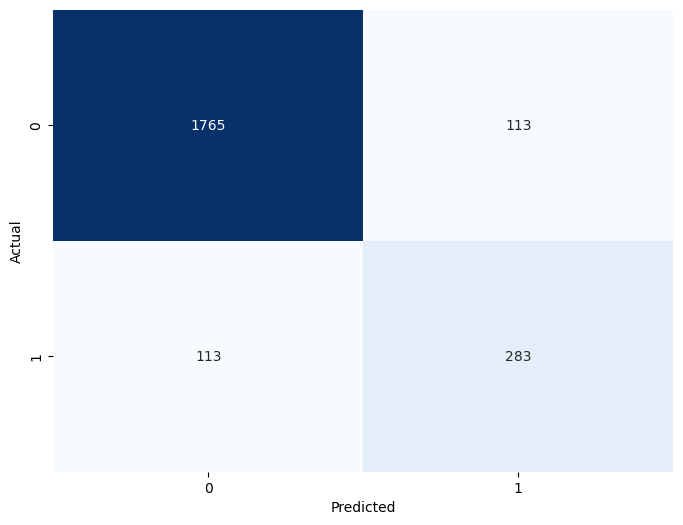

In [6]:
def tune_hyperparameters(X_train, y_train, X_test, y_test):
    param_grid = {
        'lstm_units': [32, 64, 128],
        'dropout_rate': [0.2, 0.3],
        'learning_rate': [0.001, 0.005],
        'batch_size': [32, 64],
        'epochs': [10]
    }
    
    best_model = None
    best_f1_score = 0
    best_params = None
    best_history = None  # To store the history of the best model

    for lstm_units in param_grid['lstm_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for learning_rate in param_grid['learning_rate']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        print("\n" + "="*60)
                        print(f"Testing parameters:\nLSTM units: {lstm_units}\nDropout rate: {dropout_rate}\nLearning rate: {learning_rate}\nBatch size: {batch_size}\nEpochs: {epochs}")
                        print("="*60)

                        model = create_lstm_model(lstm_units, dropout_rate, learning_rate)
                        
                        history = model.fit(
                            X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
                        )
                        
                        # Evaluate the model
                        y_pred_probs = model.predict(X_test)
                        y_pred = (y_pred_probs > 0.5).astype(int)
                        
                        # Calculate F1 score
                        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
                        
                        print(f"Evaluation results:\nF1 Score: {f1:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\n")
                        
                        if f1 > best_f1_score:
                            best_f1_score = f1
                            best_model = model
                            best_params = {
                                'lstm_units': lstm_units,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'batch_size': batch_size,
                                'epochs': epochs
                            }
                            best_history = history  # Store the history of the best model
                            print("Best model updated!")
                            
    return best_model, best_params, best_history

def plot_model_performance(history):
    # Extracting the training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the loss
    plt.figure(figsize=(12, 6))

    # Plot Training vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1 Score
    f1_score = history.history.get('f1_score', [])
    val_f1_score = history.history.get('val_f1_score', [])
    epochs = range(1, len(f1_score) + 1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, f1_score, label='Training F1 Score')
    if val_f1_score:
        plt.plot(epochs, val_f1_score, label='Validation F1 Score')
    plt.title('Training vs Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Perform hyperparameter tuning
best_model, best_params, best_history = tune_hyperparameters(X_train_pad, y_train, X_test_pad, y_test)

# Evaluate the best model
y_pred_probs = best_model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("\nTuned Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nBest Hyperparameters:")
print(best_params)

from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
#    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)


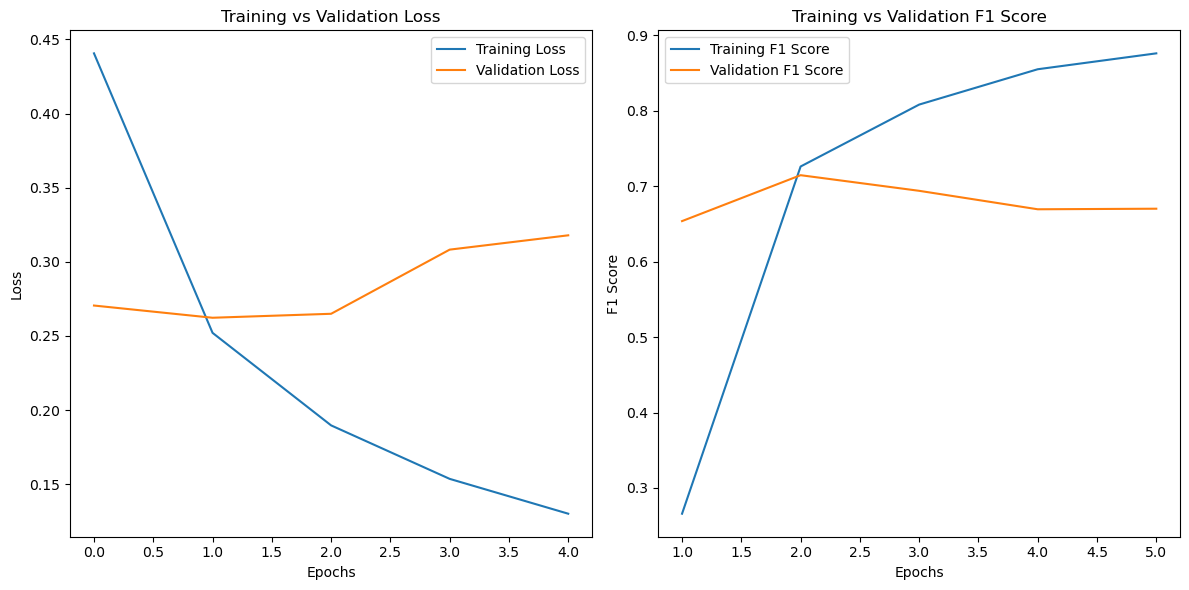

In [7]:
# Plot the best model performance
plot_model_performance(best_history)

### Load BERT Tokeniser

In [8]:
# Load BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode text in batches to avoid memory issues
def encode_texts_in_batches(texts, tokenizer, batch_size=32, max_len=128):
    input_ids = []
    attention_masks = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_input_ids = []
        batch_attention_masks = []
        
        for text in batch_texts:
            encoded = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='tf',
                truncation=True
            )
            batch_input_ids.append(encoded['input_ids'])
            batch_attention_masks.append(encoded['attention_mask'])
        
        input_ids.append(tf.concat(batch_input_ids, axis=0))
        attention_masks.append(tf.concat(batch_attention_masks, axis=0))
    
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

X_train_input_ids, X_train_attention_masks = encode_texts_in_batches(X_train, bert_tokenizer)
X_test_input_ids, X_test_attention_masks = encode_texts_in_batches(X_test, bert_tokenizer)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [9]:
# Extract BERT embeddings in batches to avoid memory issues
def get_bert_embeddings_in_batches(input_ids, attention_masks, model, batch_size=32):
    embeddings = []
    
    for i in range(0, input_ids.shape[0], batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_masks = attention_masks[i:i+batch_size]
        
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        batch_embeddings = outputs.last_hidden_state
        embeddings.append(batch_embeddings)
    
    return tf.concat(embeddings, axis=0)

X_train_embeddings = get_bert_embeddings_in_batches(X_train_input_ids, X_train_attention_masks, bert_model)
X_test_embeddings = get_bert_embeddings_in_batches(X_test_input_ids, X_test_attention_masks, bert_model)

### Model fitting and evaluation of BiLSTM with BERT Embedding

Epoch 1/10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 76s 125ms/step - f1_score: 0.3840 - loss: 0.4118 - val_f1_score: 0.4931 - val_loss: 0.3012
Epoch 2/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 67s 118ms/step - f1_score: 0.5902 - loss: 0.3331 - val_f1_score: 0.6491 - val_loss: 0.2955
Epoch 3/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 66s 117ms/step - f1_score: 0.6260 - loss: 0.3045 - val_f1_score: 0.6056 - val_loss: 0.2797
Epoch 4/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 67s 117ms/step - f1_score: 0.6531 - loss: 0.2944 - val_f1_score: 0.6211 - val_loss: 0.2759
Epoch 5/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - f1_score: 0.6879 - loss: 0.2711 - val_f1_score: 0.6149 - val_loss: 0.2727
Epoch 6/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - f1_score: 0.6896 - loss: 0.2583 - val_f1_score: 0.6306 - val_loss: 0.2803
Epoch 7/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 63s 111ms/step - f1_score: 0.7267 - loss: 0.2380 - val_f1_score: 0.6566 - val_loss: 0.2733
Epoch 8/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 61s 107ms/step - f1_score: 0.7648 - loss: 0.2109 - val

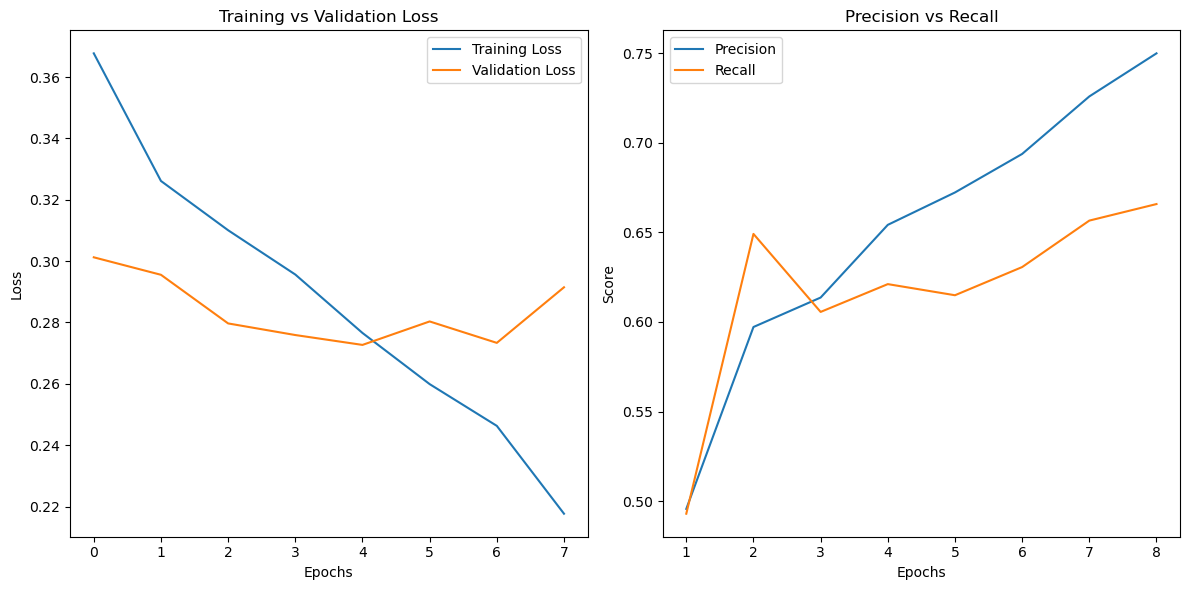

In [10]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), input_shape=(128, 768)))
lstm_model.add(Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[F1Score()])

# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train_embeddings, y_train,
    validation_data=(X_test_embeddings, y_test),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), ModelCheckpoint('best_bert_lstm_model.keras', save_best_only=True, monitor='val_loss')]
)

def plot_model_performance(history):
    # Extracting the training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the loss
    plt.figure(figsize=(12, 6))

    # Plot Training vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Precision vs Recall
    precision = history.history['f1_score']
    recall = history.history.get('val_f1_score', None)
    epochs = range(1, len(precision) + 1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, precision, label='Precision')
    if recall:
        plt.plot(epochs, recall, label='Recall')
    plt.title('Precision vs Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the performance of the LSTM model trained with BERT embeddings
plot_model_performance(lstm_history)


In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Make predictions on the test set
y_pred_probs = lstm_model.predict(X_test_embeddings)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and f1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Print the evaluation metrics
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print the classification report for a detailed view
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step

Model Evaluation:
Accuracy: 0.8887
Precision: 0.7739
Recall: 0.5101
F1 Score: 0.6149

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1878
           1       0.77      0.51      0.61       396

    accuracy                           0.89      2274
   macro avg       0.84      0.74      0.77      2274
weighted avg       0.88      0.89      0.88      2274



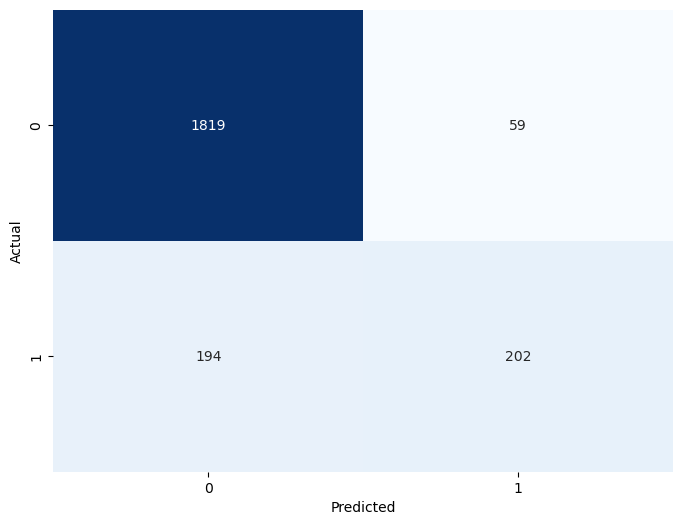

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
#    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

### Hyper Parameter Tuning of BiLSTM model with BERT


Testing parameters: LSTM units = 32, Dropout rate = 0.2, Learning rate = 0.001, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
F1 Score for this combination: 0.6333
New best model found with F1 Score: 0.6333

Testing parameters: LSTM units = 32, Dropout rate = 0.2, Learning rate = 0.001, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
F1 Score for this combination: 0.6685
New best model found with F1 Score: 0.6685

Testing parameters: LSTM units = 32, Dropout rate = 0.2, Learning rate = 0.005, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step
F1 Score for this combination: 0.6657

Testing parameters: LSTM units = 32, Dropout rate = 0.2, Learning rate = 0.005, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
F1 Score for this combination: 0.6295

Testing parameters: LSTM units = 32, Dropout rate = 0.3, Learning rate = 0.001, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
F1 Score for this combination: 0.6461

Testing parameters: LSTM units = 32, Dropout rate = 0.3, Learning rate = 0.001, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
F1 Score for this combination: 0.6732
New best model found with F1 Score: 0.6732

Testing parameters: LSTM units = 32, Dropout rate = 0.3, Learning rate = 0.005, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
F1 Score for this combination: 0.6676

Testing parameters: LSTM units = 32, Dropout rate = 0.3, Learning rate = 0.005, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step
F1 Score for this combination: 0.6512

Testing parameters: LSTM units = 64, Dropout rate = 0.2, Learning rate = 0.001, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step
F1 Score for this combination: 0.6466

Testing parameters: LSTM units = 64, Dropout rate = 0.2, Learning rate = 0.001, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
F1 Score for this combination: 0.6090

Testing parameters: LSTM units = 64, Dropout rate = 0.2, Learning rate = 0.005, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step
F1 Score for this combination: 0.6400

Testing parameters: LSTM units = 64, Dropout rate = 0.2, Learning rate = 0.005, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step
F1 Score for this combination: 0.6235

Testing parameters: LSTM units = 64, Dropout rate = 0.3, Learning rate = 0.001, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step
F1 Score for this combination: 0.6156

Testing parameters: LSTM units = 64, Dropout rate = 0.3, Learning rate = 0.001, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step
F1 Score for this combination: 0.6440

Testing parameters: LSTM units = 64, Dropout rate = 0.3, Learning rate = 0.005, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step
F1 Score for this combination: 0.5987

Testing parameters: LSTM units = 64, Dropout rate = 0.3, Learning rate = 0.005, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step
F1 Score for this combination: 0.6453

Testing parameters: LSTM units = 128, Dropout rate = 0.2, Learning rate = 0.001, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step
F1 Score for this combination: 0.6648

Testing parameters: LSTM units = 128, Dropout rate = 0.2, Learning rate = 0.001, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step
F1 Score for this combination: 0.6685

Testing parameters: LSTM units = 128, Dropout rate = 0.2, Learning rate = 0.005, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step
F1 Score for this combination: 0.6429

Testing parameters: LSTM units = 128, Dropout rate = 0.2, Learning rate = 0.005, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step
F1 Score for this combination: 0.6335

Testing parameters: LSTM units = 128, Dropout rate = 0.3, Learning rate = 0.001, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step
F1 Score for this combination: 0.5821

Testing parameters: LSTM units = 128, Dropout rate = 0.3, Learning rate = 0.001, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 205ms/step
F1 Score for this combination: 0.5903

Testing parameters: LSTM units = 128, Dropout rate = 0.3, Learning rate = 0.005, Batch size = 32, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step
F1 Score for this combination: 0.6614

Testing parameters: LSTM units = 128, Dropout rate = 0.3, Learning rate = 0.005, Batch size = 64, Epochs = 10


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step
F1 Score for this combination: 0.6490

Best model parameters:
lstm_units: 32
dropout_rate: 0.3
learning_rate: 0.001
batch_size: 64
epochs: 10


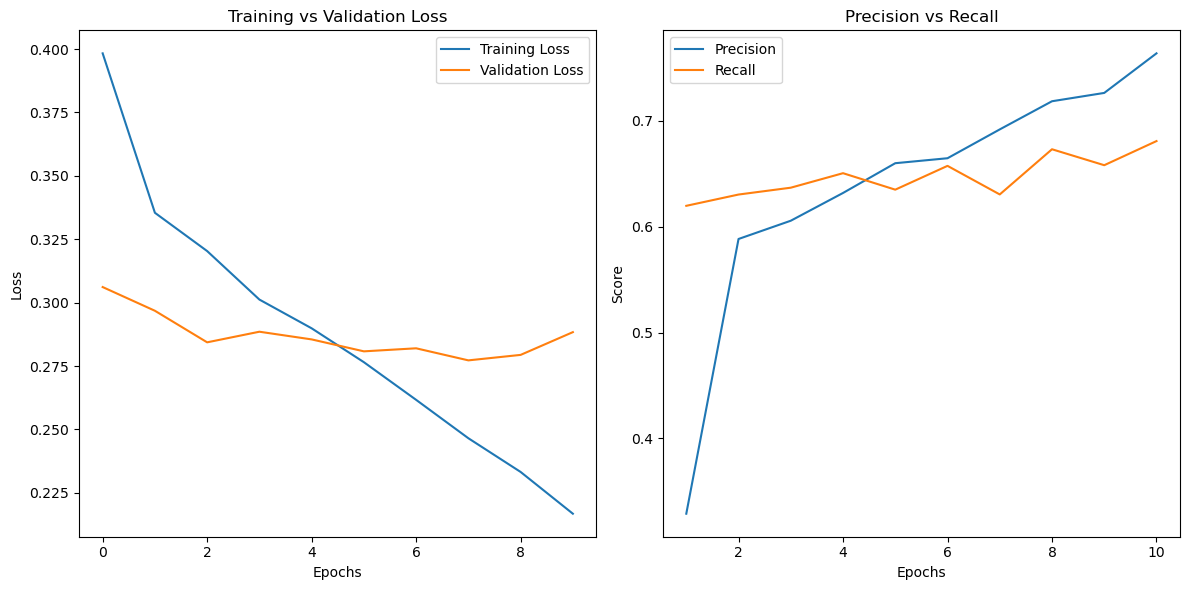

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step

Tuned Model Evaluation:
Accuracy: 0.8971
Precision: 0.7531
Recall: 0.6086
F1 Score: 0.6732

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1878
           1       0.75      0.61      0.67       396

    accuracy                           0.90      2274
   macro avg       0.84      0.78      0.81      2274
weighted avg       0.89      0.90      0.89      2274



In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

# Define the custom F1Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define a function for creating the model
def create_lstm_model(lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate), input_shape=(128, 768)))
    model.add(Bidirectional(LSTM(lstm_units // 2, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy', 
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        metrics=[F1Score()]
    )
    return model

# Function to plot model performance
def plot_model_performance(history):
    # Extracting the training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the loss
    plt.figure(figsize=(12, 6))

    # Plot Training vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Precision vs Recall
    precision = history.history['f1_score']
    recall = history.history.get('val_f1_score', None)
    epochs = range(1, len(precision) + 1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, precision, label='Precision')
    if recall:
        plt.plot(epochs, recall, label='Recall')
    plt.title('Precision vs Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define a function to perform hyperparameter tuning
def tune_hyperparameters():
    param_grid = {
        'lstm_units': [32, 64, 128],
        'dropout_rate': [0.2, 0.3],
        'learning_rate': [0.001, 0.005],
        'batch_size': [32, 64],
        'epochs': [10]
    }
    
    best_model = None
    best_f1_score = 0
    best_params = {}
    best_history = None
    
    for lstm_units in param_grid['lstm_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for learning_rate in param_grid['learning_rate']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        print(f"\nTesting parameters: LSTM units = {lstm_units}, Dropout rate = {dropout_rate}, Learning rate = {learning_rate}, Batch size = {batch_size}, Epochs = {epochs}")
                        
                        model = create_lstm_model(lstm_units, dropout_rate, learning_rate)
                        
                        history = model.fit(
                            X_train_embeddings, y_train,
                            validation_data=(X_test_embeddings, y_test),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                            verbose=0
                        )
                        
                        # Evaluate the model
                        y_pred_probs = model.predict(X_test_embeddings)
                        y_pred = (y_pred_probs > 0.5).astype(int)
                        
                        # Calculate F1 score
                        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
                        
                        print(f"F1 Score for this combination: {f1:.4f}")
                        
                        if f1 > best_f1_score:
                            best_f1_score = f1
                            best_model = model
                            best_params = {
                                'lstm_units': lstm_units,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'batch_size': batch_size,
                                'epochs': epochs
                            }
                            best_history = history
                            print(f"New best model found with F1 Score: {best_f1_score:.4f}")

    print("\nBest model parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    # Plot the performance of the best model
    if best_history is not None:
        plot_model_performance(best_history)
    
    return best_model

# Perform hyperparameter tuning
best_model = tune_hyperparameters()

# Evaluate the best model
y_pred_probs = best_model.predict(X_test_embeddings)
y_pred = (y_pred_probs > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print("\nTuned Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

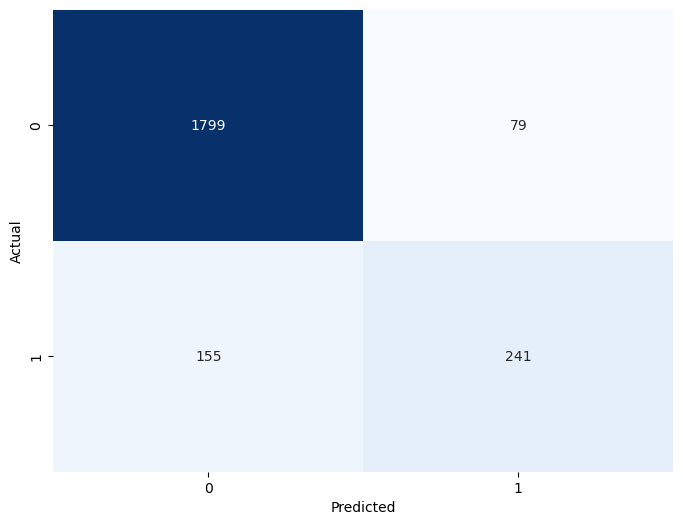

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
#    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)